import tejapi
tejapi.ApiConfig.api_key =""
data = tejapi.get('TWN/AINTRA1',coid='Y9999',mdate={'gte':'2020-03-21'},chinese_column_name=True)

data['年月日'] = data['年月日'].astype(str).astype('datetime64')
data['時間'] = data['時間'].astype(int)
data.to_csv('highFrequency.csv',index=False)
data.head(5)

In [1]:
import pandas
data = pandas.read_csv('highFrequency.csv')
data['年月日'] = data['年月日'].astype(str).astype('datetime64')
data['時間'] = data['時間'].astype(int)
data.head(5)

,證券代碼,年月日,時間,指數,委託買進筆數,委託買進張數,委託賣出筆數,委託賣出張數,成交筆數,成交張數,成交金額
0,Y9999,2020-03-23,900,9234.09,211947,2987641,153362,985831,0,0,0
1,Y9999,2020-03-23,901,8858.56,243956,3652513,181989,1166965,56798,256214,7226
2,Y9999,2020-03-23,902,8832.95,291070,4195694,216703,1267974,73621,327622,9250
3,Y9999,2020-03-23,903,8798.41,341145,4507856,251062,1368694,91241,408592,11534
4,Y9999,2020-03-23,904,8758.05,398340,4947963,287126,1460324,106499,467759,13364


In [2]:
import numpy
# 透過移動就可以產生
data['下一筆指數'] = data['指數'].values[1:len(data['指數'])].tolist()+[0]
data['前一筆指數'] = [0]+data['指數'].values[0:len(data['指數'])-1].tolist()
data['前一筆日期'] = [0]+data['年月日'].astype(str).values[0:len(data['年月日'])-1].tolist()
data['前一筆日期'] = data['前一筆日期'].astype('datetime64')
data['報酬率-Ln'] = numpy.log(data['指數']/data['前一筆指數']).replace([numpy.inf, -numpy.inf], 0)

In [4]:
print(data.loc[data['時間']==901,'報酬率-Ln'].describe())
print(data.loc[data['時間']==902,'報酬率-Ln'].describe())



count    22.000000
mean      0.005040
std       0.018033
min      -0.041518
25%      -0.001490
50%       0.007308
75%       0.014801
max       0.036117
Name: 報酬率-Ln, dtype: float64
count    22.000000
mean     -0.000292
std       0.001135
min      -0.002895
25%      -0.000806
50%      -0.000615
75%       0.000333
max       0.002819
Name: 報酬率-Ln, dtype: float64


In [5]:
data = data[data['時間']!=900]
data = data[data['時間']!=901].reset_index(drop=True)
#data.loc[data['時間']=='0901','報酬率-Ln']/=60*19
data.tail(271)

,證券代碼,年月日,時間,指數,委託買進筆數,委託買進張數,委託賣出筆數,委託賣出張數,成交筆數,成交張數,成交金額,下一筆指數,前一筆指數,前一筆日期,報酬率-Ln
5647,Y9999,2020-04-22,1329,10310.06,7732514,11597605,6666971,7008682,1347667,5016499,142732,10307.74,10310.06,2020-04-22,0.000000
5648,Y9999,2020-04-22,1330,10307.74,7748516,11609834,6678286,7082647,1388159,5225175,151797,10307.74,10310.06,2020-04-22,-0.000225
5649,Y9999,2020-04-23,902,10412.55,362734,5891730,285860,2113864,66693,237830,10564,10414.71,10402.19,2020-04-23,0.000995
5650,Y9999,2020-04-23,903,10414.71,421365,6796991,342118,2424915,84547,304591,12917,10412.52,10412.55,2020-04-23,0.000207
5651,Y9999,2020-04-23,904,10412.52,486493,8806258,403443,3003465,99834,367932,14770,10416.49,10414.71,2020-04-23,-0.000210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5913,Y9999,2020-04-23,1326,10378.43,6955760,11770587,6655542,6933288,1233745,4453615,144678,10378.43,10378.43,2020-04-23,0.000000
5914,Y9999,2020-04-23,1327,10378.43,6979423,12325271,6674811,6947609,1233745,4453615,144678,10378.43,10378.43,2020-04-23,0.000000
5915,Y9999,2020-04-23,1328,10378.43,6996092,10981523,6686614,6810069,1233745,4453615,144678,10378.43,10378.43,2020-04-23,0.000000
5916,Y9999,2020-04-23,1329,10378.43,7010883,10789513,6697794,6758417,1233745,4453615,144678,10366.51,10378.43,2020-04-23,0.000000


In [6]:
import pandas
decay_factor = 0.93
sample_size = 60
base_date = '2020-04-10'
# 透過產生index來產生日期時序表date_index，以便計算衰退因子
data_his = data[data['年月日']<=base_date].reset_index()
date_index = pandas.DataFrame(data_his['年月日'].unique(),columns=['年月日']).reset_index().rename(columns={'index':'days'})
date_index['days'] = date_index['days'].max() - date_index['days'] +1
data_his = data_his.merge(date_index,on=['年月日'],how='right')
import numpy
data_his = data_his.sort_values(by=['年月日']).reset_index(drop=True)
data_his['decay'] = numpy.power(decay_factor,data_his['days'])
mean_data = pandas.DataFrame(data_his['報酬率-Ln'].rolling(window=sample_size).mean().tolist(),columns=['roi_mu'])
mean_data['證券代碼'] = data_his['證券代碼'] 
mean_data['年月日'] = data_his['年月日'] 
mean_data['時間'] = data_his['時間'] 
mean_data = mean_data.drop_duplicates(subset=['證券代碼'],keep='last')
data_his['roi_mu'] = mean_data['roi_mu']
data_his['roi_mu'] = data_his['roi_mu'].fillna(method='bfill')
data_his['x2'] = data_his['decay']*numpy.power(data_his['報酬率-Ln'] - data_his['roi_mu'],2)
data_his['vol'] = numpy.sqrt((1-decay_factor)*data_his['x2'].rolling(window=data_his['days'].max()).sum())
data_his = data_his[(data_his['年月日']==data_his['年月日'].max())&(data_his['時間']==data_his['時間'].max())]
data_his.loc[:,['證券代碼','年月日','時間','days','decay','報酬率-Ln','roi_mu','x2','vol']]

,證券代碼,年月日,時間,days,decay,報酬率-Ln,roi_mu,x2,vol
3496,Y9999,2020-04-10,1330,1,0.93,0.000607,0.000046,2.921074e-07,0.000231


In [7]:
data_his = data_his.loc[:,['證券代碼','年月日','時間','vol']]
data = data.merge(data_his,on=['證券代碼','年月日','時間'],how='left')
data[(data['年月日']==data_his['年月日'].max())&(data['時間']==data_his['時間'].max())]

,證券代碼,年月日,時間,指數,委託買進筆數,委託買進張數,委託賣出筆數,委託賣出張數,成交筆數,成交張數,成交金額,下一筆指數,前一筆指數,前一筆日期,報酬率-Ln,vol
3496,Y9999,2020-04-10,1330,10157.61,5511633,10270127,3844516,5995256,1134394,4129938,121268,10157.61,10151.45,2020-04-10,0.000607,0.000231


In [9]:
base_date = '2020-04-10'
last_data = data_his[['證券代碼','vol']].rename(columns={'vol':'old_vol'})
all_vol_data = None
all_index_list = data[data['年月日']>base_date].index
for this_index in all_index_list:
    #取出部分資料
    last_data['old_vara'] = numpy.power(last_data['old_vol'],2)
    last_data['old_x2_sum'] = last_data['old_vara']*decay_factor
    
    this_data = data.loc[this_index:this_index,['證券代碼','年月日','時間','報酬率-Ln']].reset_index(drop=True)    
    this_data = this_data.merge(last_data,on=['證券代碼'],how='left')
    
    this_data['vara'] = numpy.power(this_data['報酬率-Ln'] ,2)*decay_factor*(1-decay_factor)+ this_data['old_x2_sum'] 
    this_data['vol'] = numpy.sqrt(this_data['vara'])
        
    last_data = this_data[['證券代碼','vol']].rename(columns={'vol':'old_vol'})

    if all_vol_data is None:
        all_vol_data = this_data
    else:
        all_vol_data = all_vol_data.append(this_data,sort=False)


In [10]:
# 比較不同時間點的平均波動度
print(all_vol_data.loc[all_vol_data['時間']==902,'vol'].describe())
print(all_vol_data.loc[all_vol_data['時間']==1330,'vol'].describe())

count    9.000000
mean     0.000377
std      0.000118
min      0.000202
25%      0.000249
50%      0.000404
75%      0.000461
max      0.000532
Name: vol, dtype: float64
count    9.000000
mean     0.000357
std      0.000101
min      0.000207
25%      0.000255
50%      0.000385
75%      0.000421
max      0.000518
Name: vol, dtype: float64


In [12]:
all_vol_data =  all_vol_data.reset_index(drop=True).reset_index()
all_vol_data

,index,證券代碼,年月日,時間,報酬率-Ln,old_vol,old_vara,old_x2_sum,vara,vol
0,0,Y9999,2020-04-13,902,0.000439,0.000231,5.323349e-08,4.950715e-08,6.204101e-08,0.000249
1,1,Y9999,2020-04-13,903,0.000389,0.000249,6.204101e-08,5.769814e-08,6.756547e-08,0.000260
2,2,Y9999,2020-04-13,904,0.000629,0.000260,6.756547e-08,6.283589e-08,8.863262e-08,0.000298
3,3,Y9999,2020-04-13,905,-0.000303,0.000298,8.863262e-08,8.242833e-08,8.841966e-08,0.000297
4,4,Y9999,2020-04-13,906,0.000338,0.000297,8.841966e-08,8.223028e-08,8.966038e-08,0.000299
...,...,...,...,...,...,...,...,...,...,...
2416,2416,Y9999,2020-04-23,1326,0.000000,0.000362,1.308275e-07,1.216696e-07,1.216696e-07,0.000349
2417,2417,Y9999,2020-04-23,1327,0.000000,0.000349,1.216696e-07,1.131527e-07,1.131527e-07,0.000336
2418,2418,Y9999,2020-04-23,1328,0.000000,0.000336,1.131527e-07,1.052320e-07,1.052320e-07,0.000324
2419,2419,Y9999,2020-04-23,1329,0.000000,0.000324,1.052320e-07,9.786579e-08,9.786579e-08,0.000313


In [36]:

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(40,20))
sns.set(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")


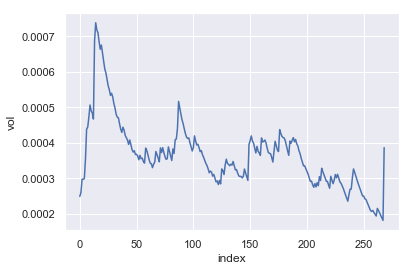

In [41]:
# Plot the responses for different events and regions
sns.lineplot(x="index", y="vol",
             data=all_vol_data[all_vol_data['年月日']=='2020-04-13'])

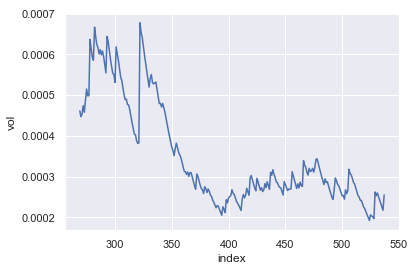

In [15]:
sns.lineplot(x="index", y="vol",
             data=all_vol_data[all_vol_data['年月日']=='2020-04-14'])

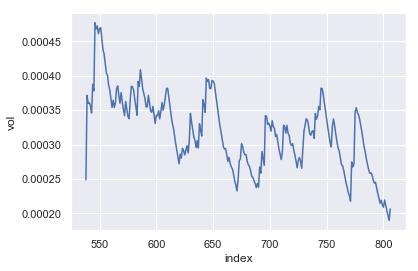

In [16]:
sns.lineplot(x="index", y="vol",
             data=all_vol_data[all_vol_data['年月日']=='2020-04-15'])

In [33]:
all_vol_data['std'] = all_vol_data['報酬率-Ln'].rolling(window=180).std()
all_vol_data[['std']] = all_vol_data[['std']].fillna(all_vol_data['std'].mean())

In [34]:
view_data = all_vol_data[['index','std']].copy().rename(columns={'std':'vol'})
view_data['kind'] = 'std'
compare_data = all_vol_data[['index','vol']].copy()
compare_data['kind'] = 'ewma'
view_data = view_data.append(compare_data,sort=False)
view_data

,index,vol,kind
0,0,0.000414,std
1,1,0.000414,std
2,2,0.000414,std
3,3,0.000414,std
4,4,0.000414,std
...,...,...,...
2416,2416,0.000349,ewma
2417,2417,0.000336,ewma
2418,2418,0.000324,ewma
2419,2419,0.000313,ewma


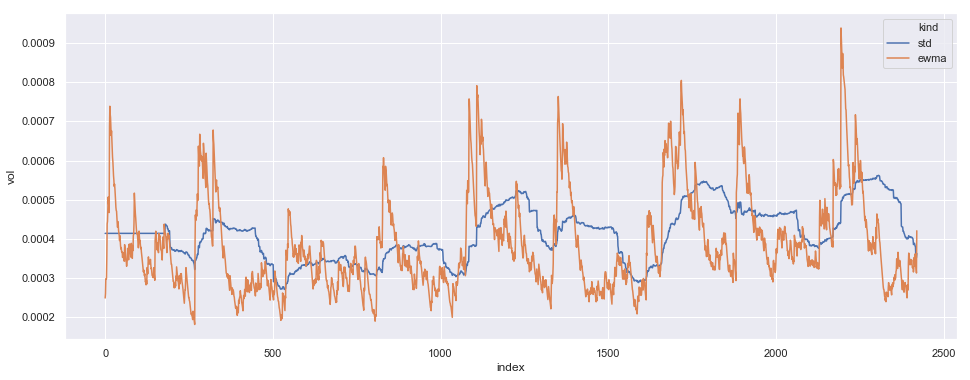

In [43]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="index", y="vol",hue='kind',
             data=view_data)